# Answering Business Questions Using SQL
*This project is guided by DataQuest.*

## Introduction and Scheme Diagram

In this project, we're going to practice using our SQL skills to answer business questions.

We will use the Chinook database. 

The relationship betweem tables is like:

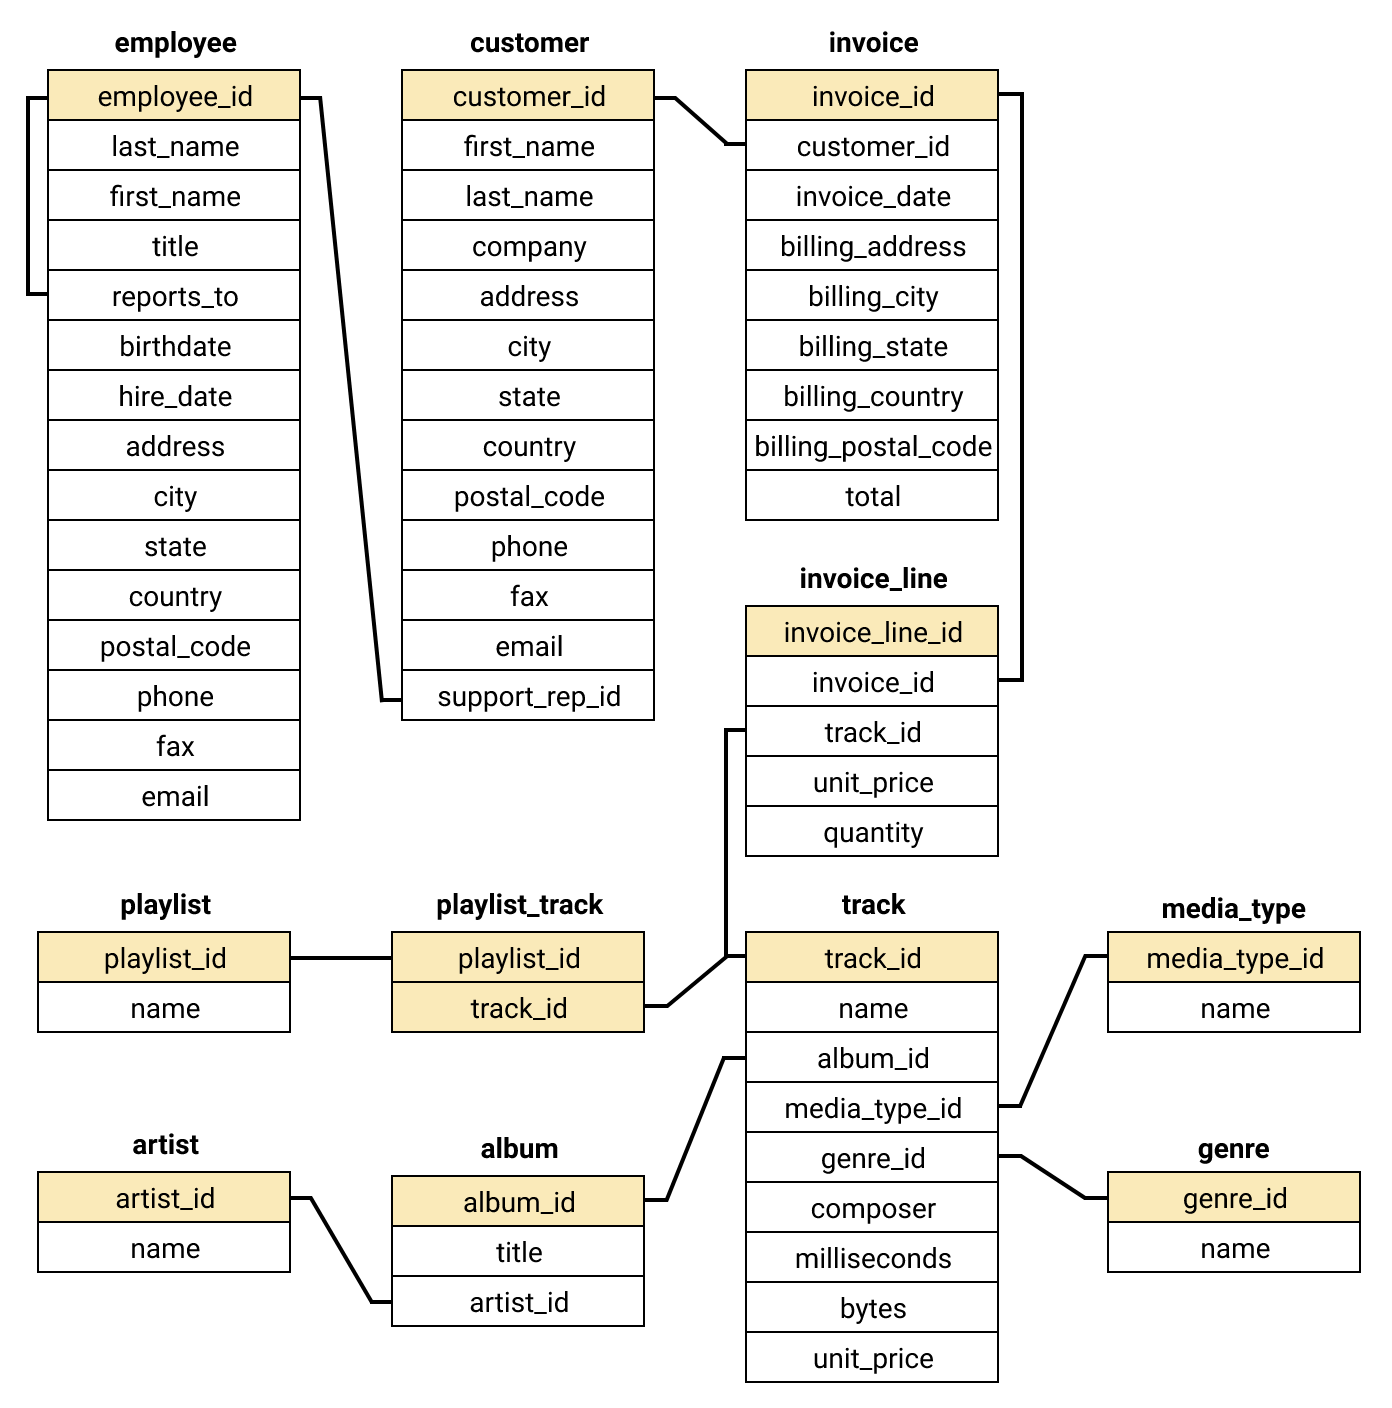

In [9]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## Overview of the Data

In [36]:
# Return information on the tables
%%sql
SELECT name, type
  FROM sqlite_master
WHERE type IN ("table","view")

SyntaxError: invalid syntax (<ipython-input-36-b1c1c2aba341>, line 3)

There are 11 tables in the dataset, containing information of albums, artists, playlists, tracks, invoice line and so on. 

## Selecting Albums to Purchase

We will start with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name|Genre|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

For this purpose, we will write a query that returns to top 10 genres with number and the percentage of tracks sold in the USA. The necessary information can be obtained from the `genre`, `track`, `invoice`, and `invoice_line` tables. 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3

In [14]:
query = """
WITH total_count AS (SELECT COUNT(t.track_id) total_count
                       FROM invoice i
                            INNER JOIN invoice_line il 
                            ON il.invoice_id = i.invoice_id
                            
                            LEFT JOIN track t 
                            ON il.track_id = t.track_id 
    
                            INNER JOIN genre g 
                            ON t.genre_id = g.genre_id 
                      WHERE i.billing_country = "USA")
                      
SELECT g.name genre,
       COUNT(t.track_id) num_tracks,
       ROUND(COUNT(t.track_id) * 100.00/(SELECT total_count 
                                           FROM total_count), 0) pct
  FROM invoice i
       INNER JOIN invoice_line il 
       ON il.invoice_id = i.invoice_id
        
       LEFT JOIN track t 
       ON il.track_id = t.track_id 
        
       INNER JOIN genre g 
       ON t.genre_id = g.genre_id         
 WHERE i.billing_country = "USA"
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;
"""

In [20]:
# Read SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn) 
df

,genre,num_tracks,pct
0,Rock,561,53.0
1,Alternative & Punk,130,12.0
2,Metal,124,12.0
3,R&B/Soul,53,5.0
4,Blues,36,3.0
5,Alternative,35,3.0
6,Pop,22,2.0
7,Latin,22,2.0
8,Hip Hop/Rap,20,2.0
9,Jazz,14,1.0


In [16]:
df = df.set_index("genre", drop = True)

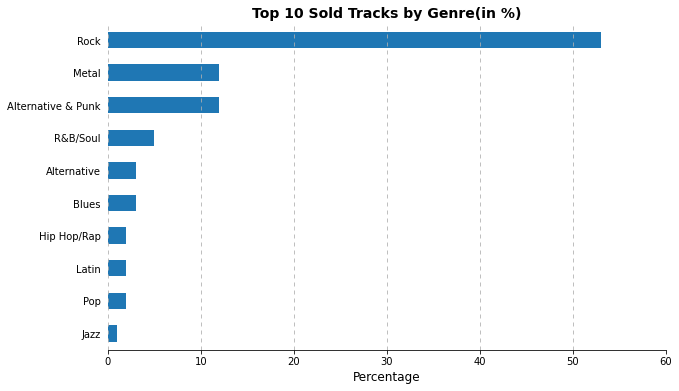

In [17]:
# Visualization
fig, ax = plt.subplots(figsize = (10,6))
df["pct"].sort_values().plot.barh(xlim = (0,60))

plt.title("Top 10 Sold Tracks by Genre(in %)", fontsize = 14, weight = "bold")
plt.xlabel("Percentage", fontsize = 12)
plt.ylabel(None)
plt.tick_params(axis="both", left = False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(dashes = (5,5), axis = 'x')

plt.show()

The most popular genres in the USA are **rock, metal, alternative&punk**, with proportions larger than other genres. 

Our choice is limited in the genres of Hip-Hop, Punk, Pop, Blues. Therefore, according to the figure above, we make three choices among four albums as follows:

|Artist Name|Genre|
|---|---|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. I will analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We are going to find the total dollar amount of sales assigned to each sales support agent within the company.

In [34]:
query_1 = '''
WITH employee_info AS (SELECT e.first_name || " " || e.last_name employee,
                              e.country,
                              e.hire_date,
                              COUNT(c.customer_id) customers_num,
                              ROUND(SUM(i.total), 0) total_sales
                        FROM employee e 
                             LEFT JOIN customer c
                             ON e.employee_id = c.support_rep_id
                             
                             INNER JOIN invoice i 
                             ON c.customer_id = i.customer_id
                        WHERE e.title = "Sales Support Agent"    
                        GROUP BY 1
                        ORDER BY 5 DESC)
                        
SELECT employee,
       country,
       hire_date,
       customers_num,
       ROUND(customers_num * 100.0/(SELECT SUM(customers_num) 
                                      FROM employee_info), 0) pct_customers,
       total_sales,
       ROUND(total_sales * 100.0/(SELECT SUM(total_sales) 
                             FROM employee_info), 0) pct_sales
  FROM employee_info;
'''

In [35]:
# Read SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df_1 = pd.read_sql_query(query_1, conn).set_index('employee', drop = True)
df_1

,country,hire_date,customers_num,pct_customers,total_sales,pct_sales
employee,,,,,,
Jane Peacock,Canada,2017-04-01 00:00:00,212,35.0,1732.0,37.0
Margaret Park,Canada,2017-05-03 00:00:00,214,35.0,1584.0,34.0
Steve Johnson,Canada,2017-10-17 00:00:00,188,31.0,1394.0,30.0


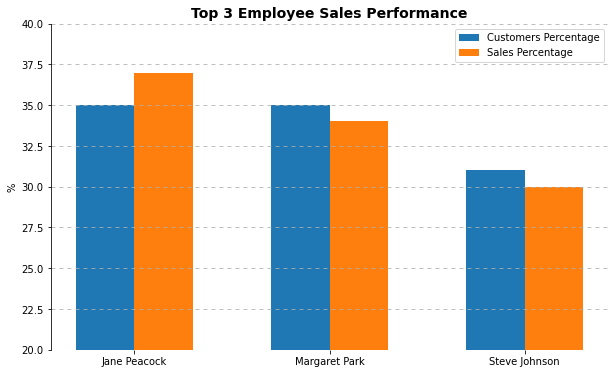

In [52]:
# Visualization
fig, ax = plt.subplots(figsize = (10,6))
x = np.arange(3)

y1 = df_1['pct_customers'].to_list()
y2 = df_1['pct_sales'].to_list()

bar_width = 0.3
tick_label = df_1.index.to_list()

plt.bar(x, y1, bar_width, label='Customers Percentage')
plt.bar(x+bar_width, y2, bar_width, label='Sales Percentage')

plt.legend()
plt.title("Top 3 Employee Sales Performance", fontsize = 14, weight = "bold")
plt.xticks(x+bar_width/2,tick_label)
plt.ylabel("%")
plt.ylim(20,40)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.grid(dashes = (5,5), axis = 'y')

plt.show()


The top 3 employees with the best sales performance are **Jane Peacock, Margaret Park, Steve Johnson**. They are all from Canada and employeed in the year of 2017 (April, May and October). 

Jane Peacock performs the best, with the highest customers percentage and sales percentage. Steve Johnson performs the worst among three employees. 

## Analyzing Sales by Country

This part is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In [53]:
query = """ 
WITH sales_per_customer AS   (SELECT c.country, 
                                     c.customer_id,
                                     ROUND(SUM(i.total), 0) total,
                                     COUNT(i.invoice_id) num_sales
                                FROM customer c
                                     INNER JOIN invoice i 
                                     ON i.customer_id=c.customer_id
                               GROUP BY 1, 2),

     all_countries AS        (SELECT c.country,
                                     COUNT(c.customer_id) customers,
                                     ROUND(SUM(spc.total), 0) total_sales,
                                     ROUND(AVG(spc.num_sales), 1) sales_per_customer,
                                     ROUND(AVG(spc.total), 0) avg_order
                                FROM customer c
                                     INNER JOIN sales_per_customer spc 
                                     ON spc.customer_id = c.customer_id
                               GROUP BY 1),  
    
     only_1_customer AS      (SELECT COUNT(country) country,
                                     COUNT(customers) customers,
                                     SUM(total_sales) total_sales,
                                     ROUND(AVG(sales_per_customer), 0) sales_per_customer, 
                                     ROUND(AVG(avg_order), 0) avg_order
                                FROM all_countries
                               WHERE customers=1),  
        
    other_countries AS       (SELECT CASE 
                                     WHEN country = (SELECT country 
                                                       FROM only_1_customer)       
                                                       THEN "Other"
                                     END AS country, 
                                     customers,
                                     total_sales, 
                                     sales_per_customer, 
                                     avg_order
                                FROM only_1_customer),
    
     more_than_1_customer AS (SELECT * 
                                FROM all_countries 
                               WHERE customers > 1
                               ORDER BY 1),
        
     united_unsorted AS      (SELECT * FROM other_countries
                               UNION 
                              SELECT * FROM more_than_1_customer)   
                              
SELECT country,
       customers,
       ROUND(customers * 100.0/(SELECT SUM(customers) 
                                      FROM united_unsorted), 0) pct_customers,
       total_sales,
       ROUND(total_sales * 100.0/(SELECT SUM(total_sales) 
                                      FROM united_unsorted), 0) pct_sales,       
       sales_per_customer,
       avg_order
  FROM (SELECT united_unsorted.*,
               CASE
               WHEN united_unsorted.country = "Other" THEN 1
               ELSE 0
               END AS sort
          FROM united_unsorted)
 ORDER BY sort ASC, 4 DESC;
"""

In [55]:
# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("country", drop=True)
df

,customers,pct_customers,total_sales,pct_sales,sales_per_customer,avg_order
country,,,,,,
USA,13,22.0,1038.0,22.0,10.1,80.0
Canada,8,14.0,535.0,11.0,9.5,67.0
Brazil,5,8.0,427.0,9.0,12.2,85.0
France,5,8.0,388.0,8.0,10.0,78.0
Germany,4,7.0,334.0,7.0,10.3,84.0
Czech Republic,2,3.0,274.0,6.0,15.0,137.0
United Kingdom,3,5.0,245.0,5.0,9.3,82.0
Portugal,2,3.0,185.0,4.0,14.5,93.0
India,2,3.0,183.0,4.0,10.5,92.0


The sales by country are evidently dominated by the USA, in terms of both the total sales and the number of customers (if not to count the "Other" group). Besides, we can notice a strong positive correlation between the number of customers and the total sales. Interesting that Czech Republic, having only 2 customers, shows the highest average value of sales per customer and, consequently, the highest average order value.

## Albums VS. Individual Tracks

In [56]:
query = """ 
WITH invoice_album AS   (SELECT il.invoice_id,                                     
                                t.album_id
                           FROM invoice_line il
                                LEFT JOIN track t 
                                ON t.track_id = il.track_id
                          GROUP BY 1),

     album_vs_tracks AS (SELECT ia.*,
                                CASE
                                WHEN (SELECT il.track_id 
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id
                                      EXCEPT                                          
                                      SELECT t.track_id 
                                        FROM track t
                                       WHERE t.album_id = ia.album_id) IS NULL
                             
                                 AND (SELECT t.track_id 
                                        FROM track t
                                       WHERE t.album_id = ia.album_id                                         
                                      EXCEPT                                          
                                      SELECT il.track_id 
                                        FROM invoice_line il
                                       WHERE il.invoice_id = ia.invoice_id) IS NULL
                                   
                                THEN "Albums"
                                ELSE "Tracks"
                                END AS purchase                             
                           FROM invoice_album ia)
                           
SELECT purchase,
       COUNT(*) num_invoices,
       ROUND(COUNT(*) * 100.0 /(SELECT COUNT(*)
                                  FROM invoice), 0) pct
  FROM album_vs_tracks
 GROUP BY 1
 ORDER BY 2 DESC;
"""

In [57]:
# Reading SQL results into a pandas DataFrame
conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn).set_index("purchase", drop=True)
print("\n")
print(df)
print("\n")



          num_invoices   pct
purchase                    
Tracks             500  81.0
Albums             114  19.0




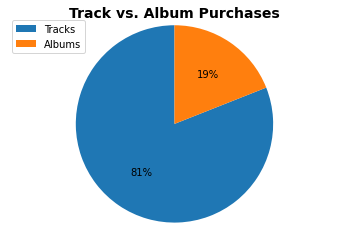

In [65]:
# Creating labels from the index
labels = df.index.tolist()

# Selecting data to plot
sizes = df["pct"]

# Plotting the data using a pie chart
fig, ax = plt.subplots()
ax.pie(sizes, 
       autopct="%1.0f%%", 
       startangle=90)
ax.axis("equal")  # Equal aspect to draw the pie as a circle
ax.set_title("Track vs. Album Purchases", 
             fontsize = 14, 
             y=0.96, weight = 'bold')
plt.legend(labels = labels)

plt.show()

Customers tend to buy individual tracks 4 times more often than the whole albums. This means that the new strategy in consideration (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) will definitely help to maximize the overall revenue.